Notebook initialization:

You need to run the next 3 cells!

In [1]:
# import necessary modules
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy_sz import Class
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import math

Esthetic definitions for the plots

In [2]:
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

Common settings for cosmological parameters and other CLASS parameters

In [3]:
common_settings = {
                   # LambdaCDM parameters
                   'h':0.67556,
                   'omega_b':0.022032,
                   'omega_cdm':0.12038,
                   'A_s':2.215e-9,
                   'tau_reio':0.0925,
                   # Take fixed value for primordial Helium (instead of automatic BBN adjustment)
                   'YHe':0.246,
}


# CIB monopole
CIB model based on Mccarthy, Madhavacheril, also Manyar+, Planck+

In [8]:

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'mass function': 'T10',
        'concentration parameter' : 'D08',
       'hm_consistency': 1,
       'output':'cib_monopole', 
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,
        

        
        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,


        'M_min' : 1e6*common_settings['h'],
        'M_max' : 1e16*common_settings['h'],
        'z_min' : 1e-3,
        'z_max' : 9,
        'freq_min': 2e2,
        'freq_max': 4e3,
        'dlogfreq' : 0.05    
        })
        
M.compute()


In [9]:
nu_arr = []
I0_arr = []
for z_min in np.linspace(0.01,6.,10):
    M.set({'z_min' : z_min})
    M.compute()
    nu_arr.append(M.cib_monopole()['nu'])
    I0_arr.append(M.cib_monopole()['I0'])


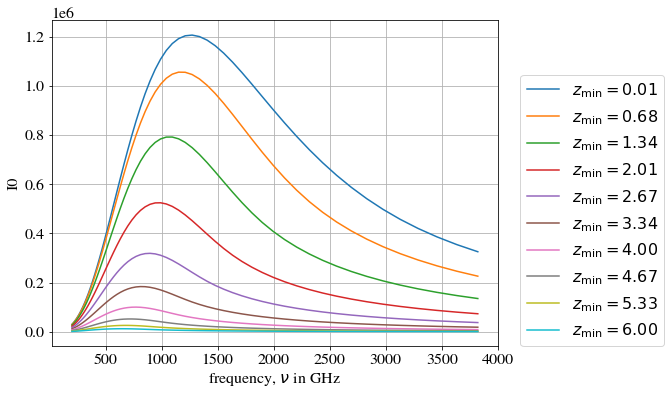

In [10]:
for (iz,z_min) in enumerate(np.linspace(0.01,6.,10)):
    plt.plot(nu_arr[iz],I0_arr[iz],label=r'$z_\mathrm{min}=%.2f$'%z_min)
plt.xlabel(r'frequency, $\nu$ in GHz')
plt.ylabel('I0')
plt.grid(which='both')
plt.legend(loc=(1.05,0.))

# CIB redshift kernel

In [12]:

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
        'mass function': 'T10',
        'concentration parameter' : 'D08',
        'hm_consistency': 1,
       'output':'dcib0dz', 
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        
        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,


        'M_min' : 1e6*common_settings['h'],
        'M_max' : 1e16*common_settings['h'],
        'z_min' : 1e-3,
        'z_max' : 9,
        'freq_min': 2e2,
        'freq_max': 4e3,
    
        })
        
M.compute()


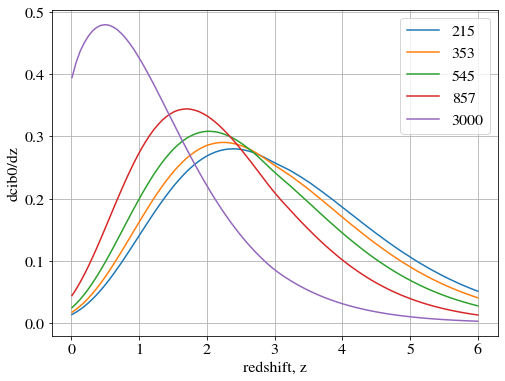

In [13]:
get_dcib0dz_at_z_and_nu = np.vectorize(M.get_dcib0dz_at_z_and_nu)
nu_arr  = [215,353,545,857,3000] # in GHz
for nu in nu_arr:
    z = np.linspace(0.01,6.,100)
    dcib0dz = nu*get_dcib0dz_at_z_and_nu(z,nu)
    norm = np.trapz(dcib0dz,z)
    plt.plot(z,dcib0dz/norm,label=str(nu))
plt.xlabel('redshift, z')
plt.ylabel('dcib0/dz')
plt.grid(which='both')
plt.legend()

# CIB power spectrum
Mccarthy, Madhavacheril, also Manyar+, Planck+

In [23]:
specs = ['f090xf090','f090xf100','f090xf143','f090xf150',
 'f090xf217','f090xf353','f090xf545','f100xf100',
 'f100xf143','f143xf143','f100xf150','f143xf150',
 'f150xf150','f150xf217','f150xf353','f150xf545',
 'f100xf217','f143xf217','f217xf217','f100xf353',
 'f143xf353','f217xf353','f353xf353','f100xf545',
 'f143xf545','f217xf545','f353xf545','f545xf545']
    
freqs_asked = []
fband1 = []
fband2 = []
for spec in specs:
    comp1 = spec.split('x')[0]
    comp2 = spec.split('x')[1]
    comp1 = comp1.replace('f', '')
    comp2 = comp2.replace('f', '')
    fband1.append(comp1)
    fband2.append(comp2)
    # print(comp1,comp2)
    if comp1 not in freqs_asked:
        freqs_asked.append(comp1)
    if comp2 not in freqs_asked:
        freqs_asked.append(comp2)
freqs_asked.sort()

In [24]:
str(freqs_asked).replace('[', '')
str(freqs_asked).replace(']', '')

"['090', '100', '143', '150', '217', '353', '545'"

In [40]:

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'cib_cib_1h,cib_cib_2h', 
    
        'mass function': 'T10',
        'concentration parameter' : 'D08',
        'hm_consistency': 1,
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M_min' : 1e10*common_settings['h'],
        'M_max' : 1e16*common_settings['h'],
        'z_min' : 0.07,
        'z_max' : 6,
        'ell_min': 10.,
        'ell_max':5e4,
        'dlogell':0.2,
    
       'cib_frequency_list_num' : 11,
       'cib_frequency_list_in_GHz' : '30,44,70,90, 100, 143, 150, 217,220, 353, 545',
        })
        
M.compute()
cl_cib_cib = M.cl_cib_cib()
M.struct_cleanup()
M.empty()

In [41]:
np.save('class_sz_planck_act_cib-cross-auto_w220.npy', cl_cib_cib)

In [42]:
file_cib = np.load('class_sz_planck_act_cib-cross-auto_w220.npy',allow_pickle='TRUE')
# npzfile.files
file_cib

array({'30x30': {'ell': [10.000000000000002, 12.214027581601703, 14.918246976412705, 18.221188003905095, 22.255409284924678, 27.182818284590457, 33.20116922736549, 40.55199966844677, 49.53032424395116, 60.496474644129464, 73.89056098930652, 90.25013499434124, 110.23176380641608, 134.637380350017, 164.4464677109705, 200.85536923187672, 245.32530197109358, 299.6410004739703, 365.9823444367801, 447.01184493300826, 545.9815003314425, 666.8633104092517, 814.5086866496816, 994.8431564193388, 1215.10417518735, 1484.1315910257663, 1812.7224187515126, 2214.0641620418724, 2704.264074261528, 3302.9955990964927, 4034.2879349273558, 4927.490410932564, 6018.450378720819, 7350.951892419735, 8978.472916504194, 10966.331584284599, 13394.307643944183, 16359.84429995926, 19981.958951041193, 24406.019776245033, 29809.579870417314, 36409.50307332356, 44470.66747699855], '1h': [0.012973935339045417, 0.023620360742149463, 0.04330677957140116, 0.07991456475968967, 0.14807416599916678, 0.27440763466368445, 0.5

/var/folders/_q/j04c9lw93j75_c_z2jdfbtwm0000gn/T/ipykernel_88249/3294077406.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


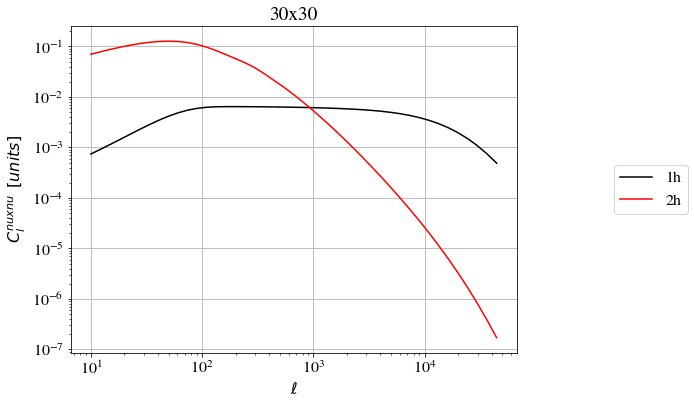

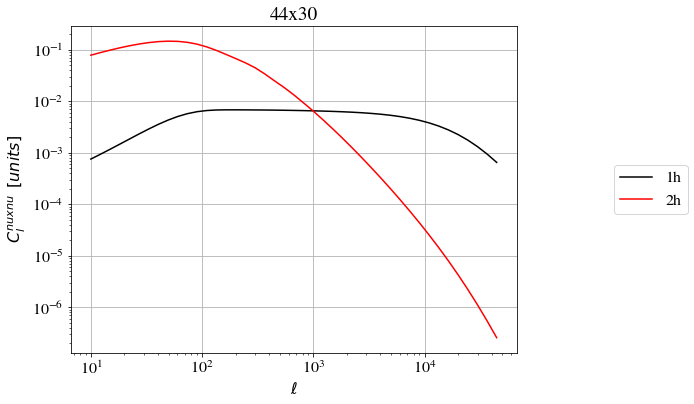

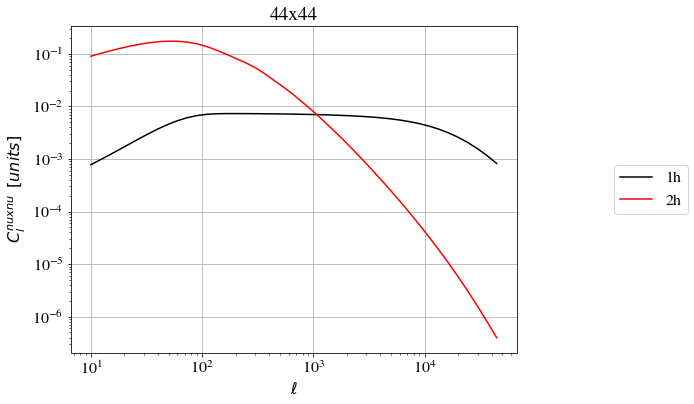

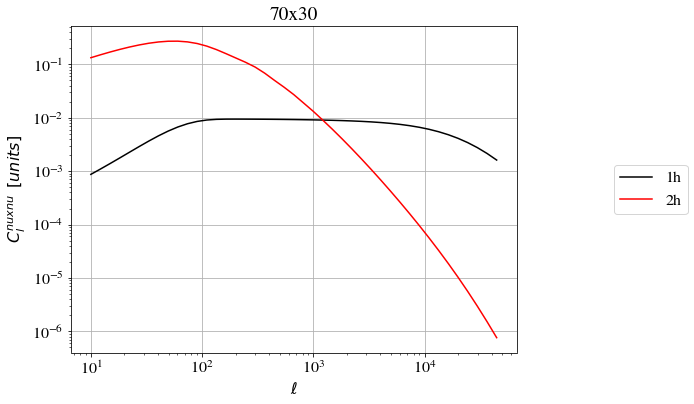

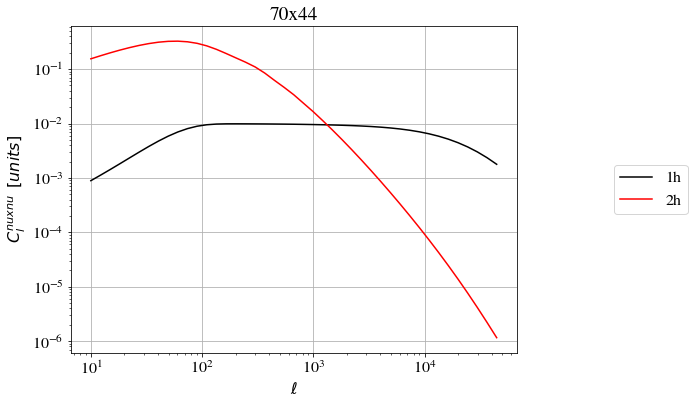

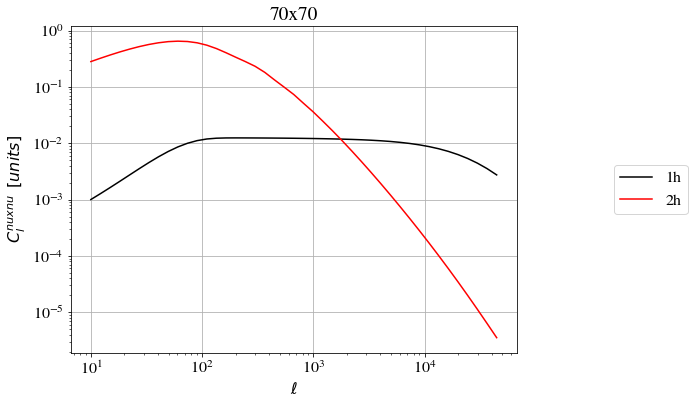

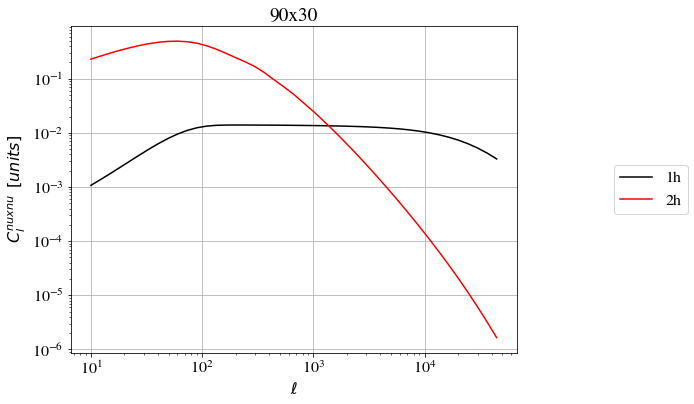

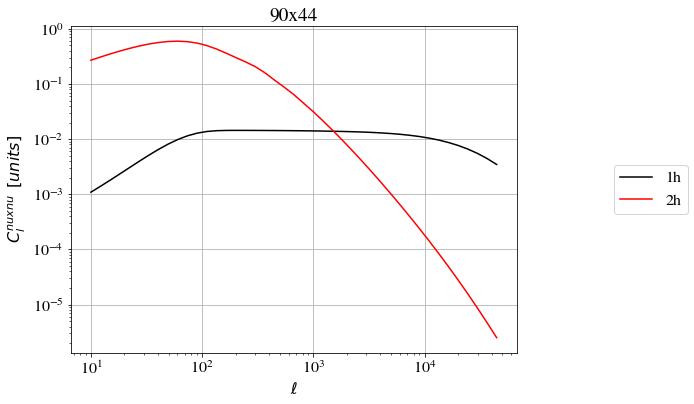

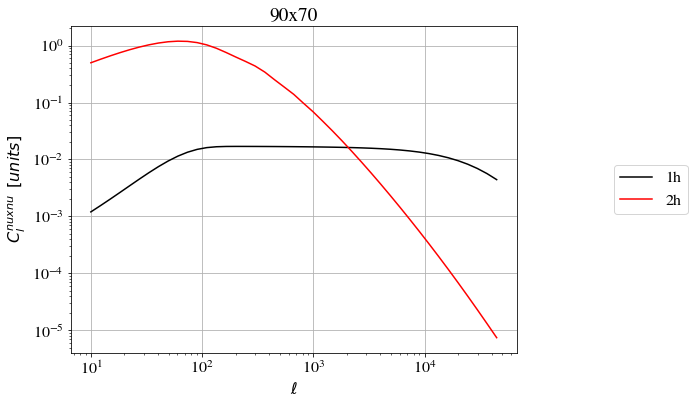

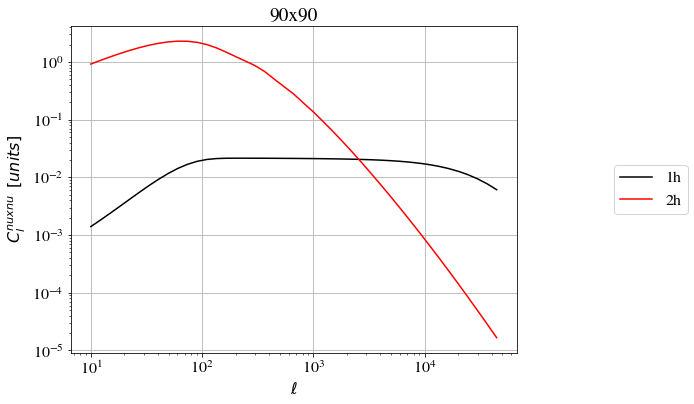

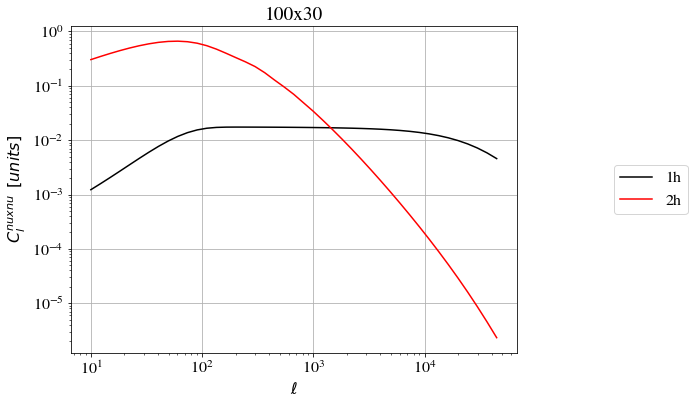

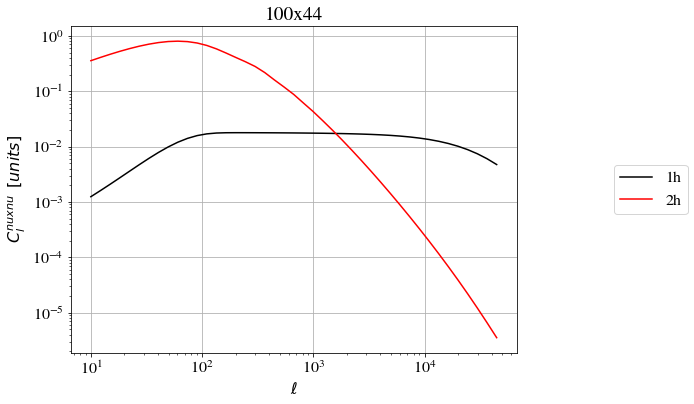

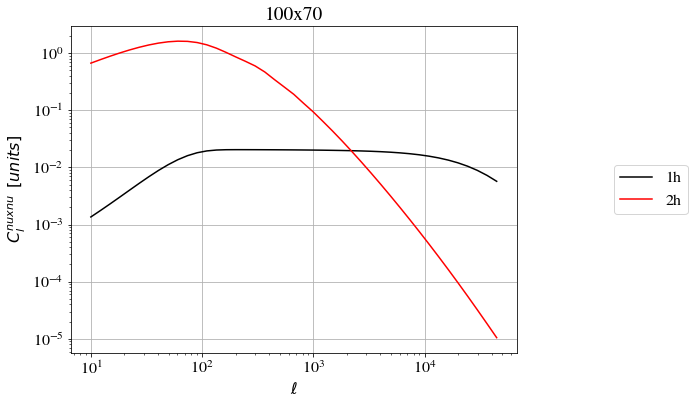

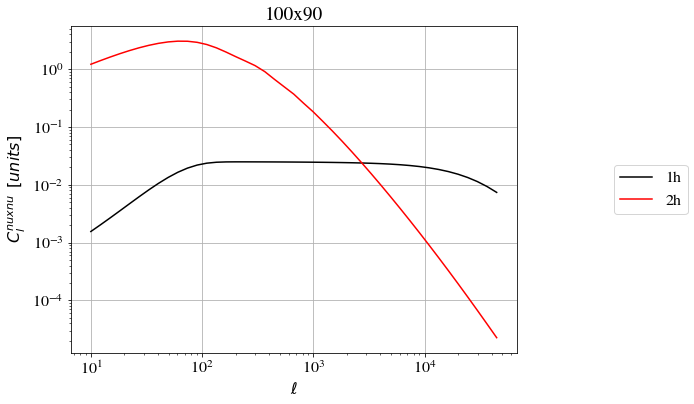

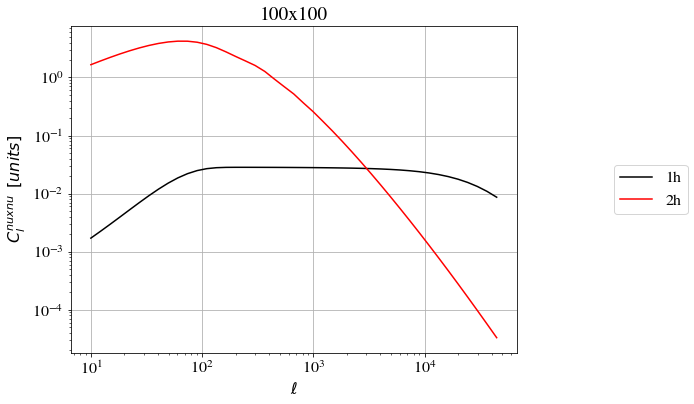

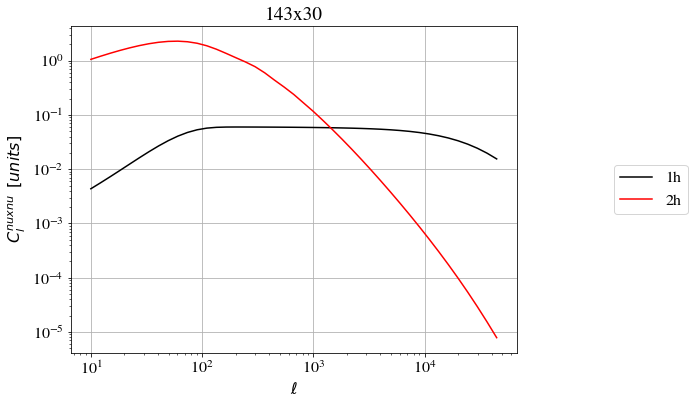

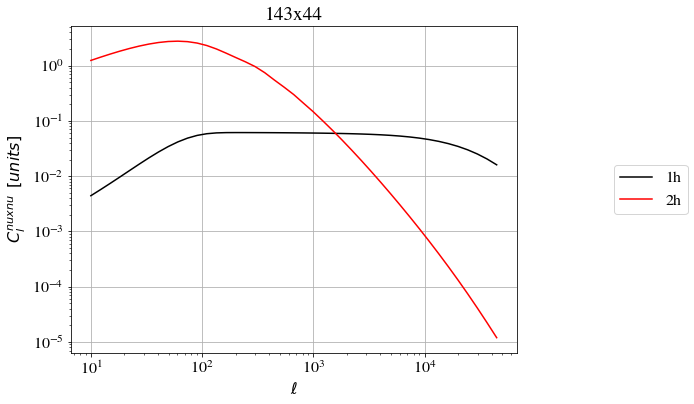

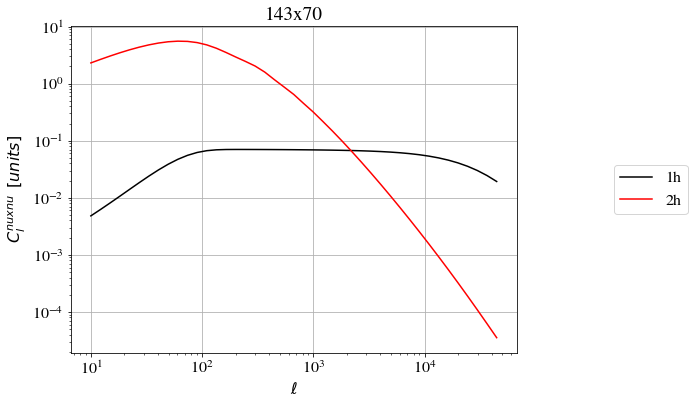

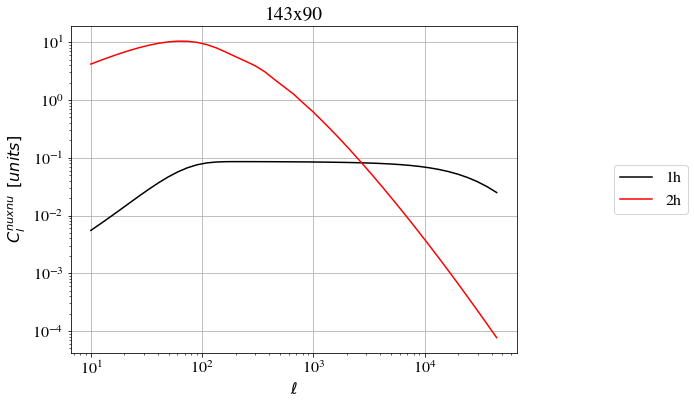

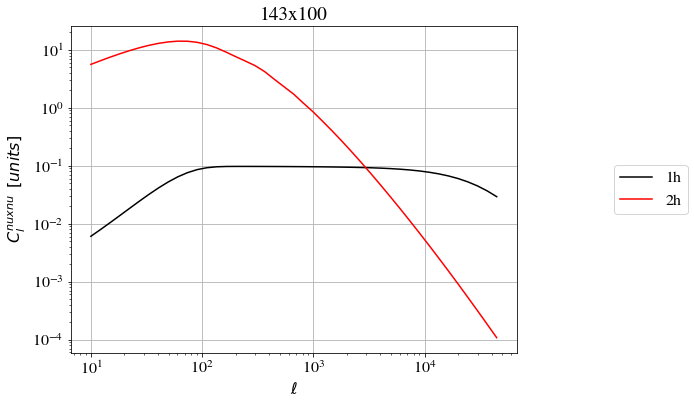

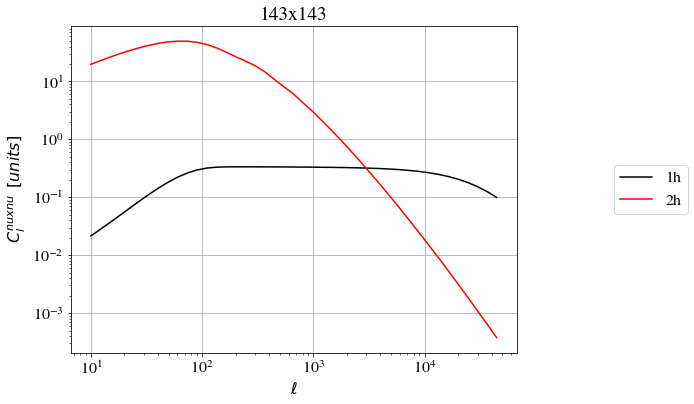

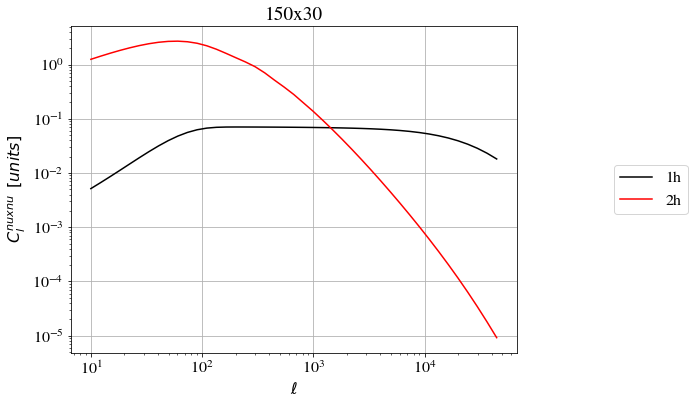

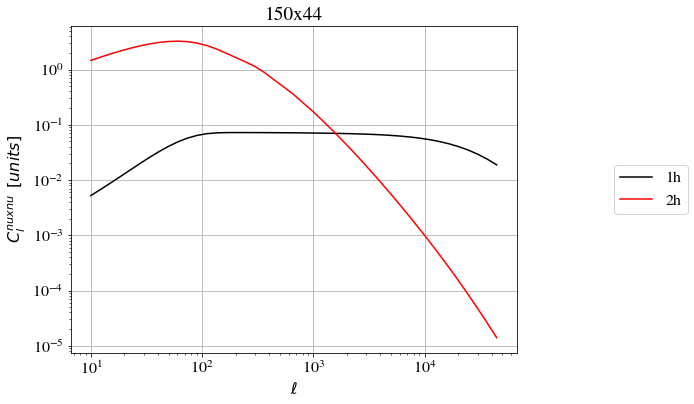

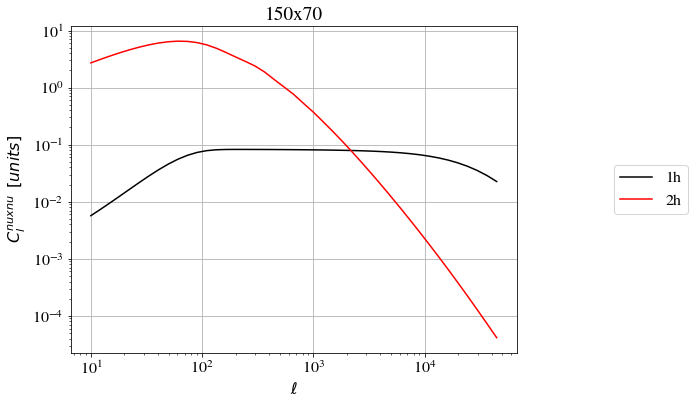

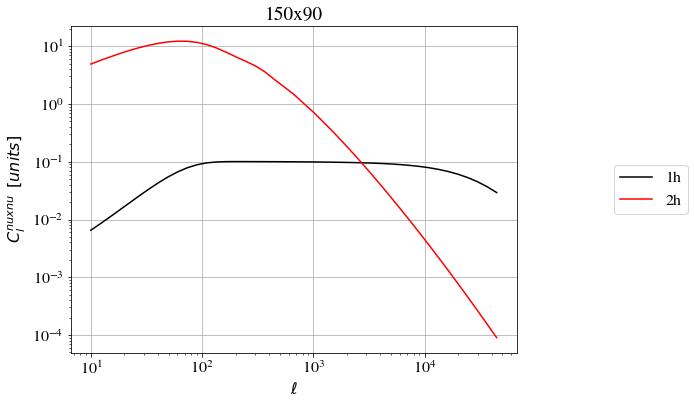

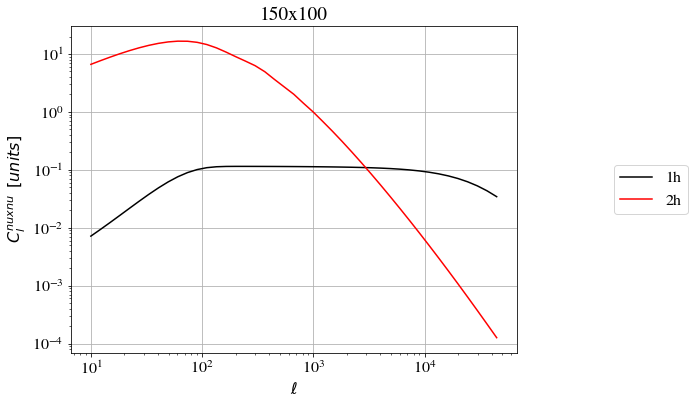

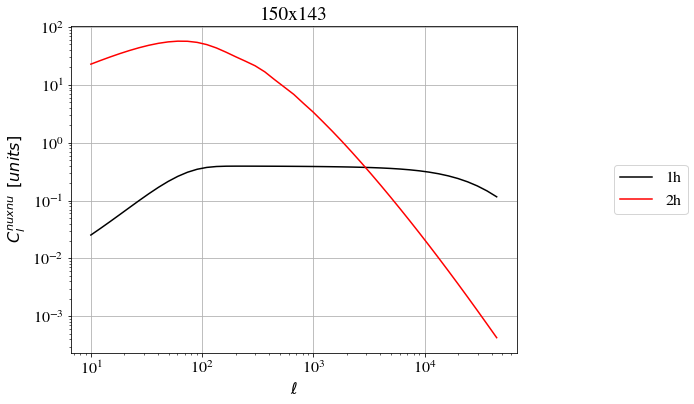

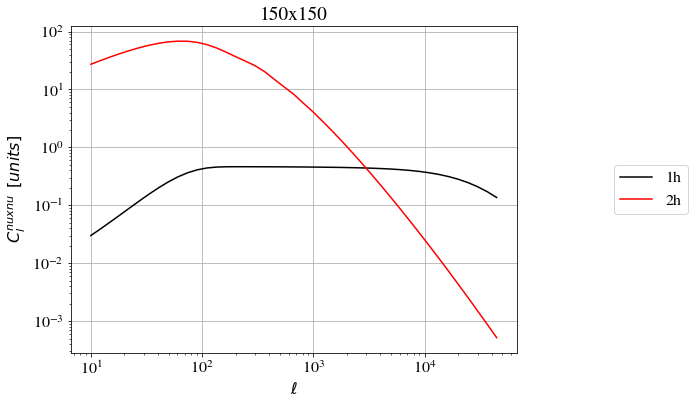

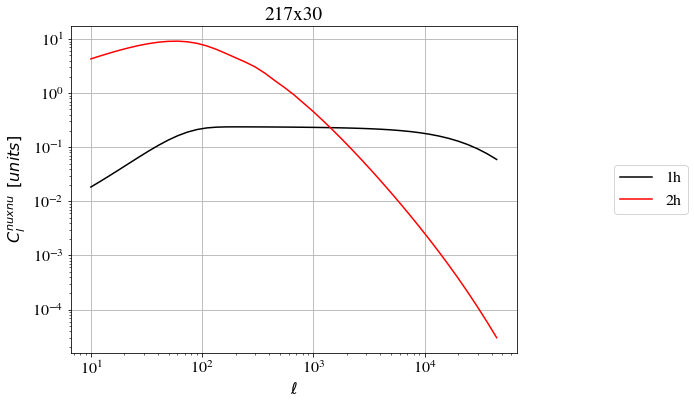

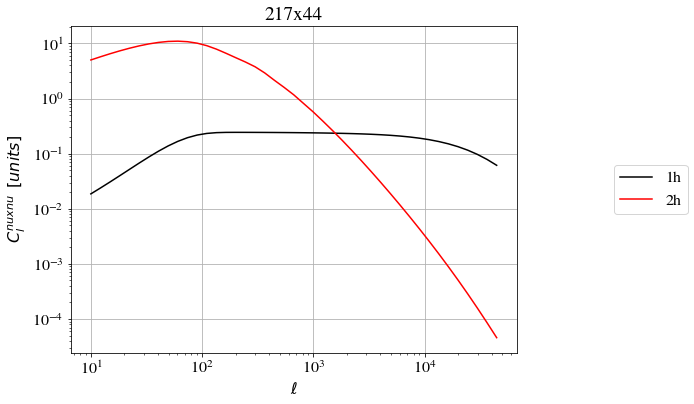

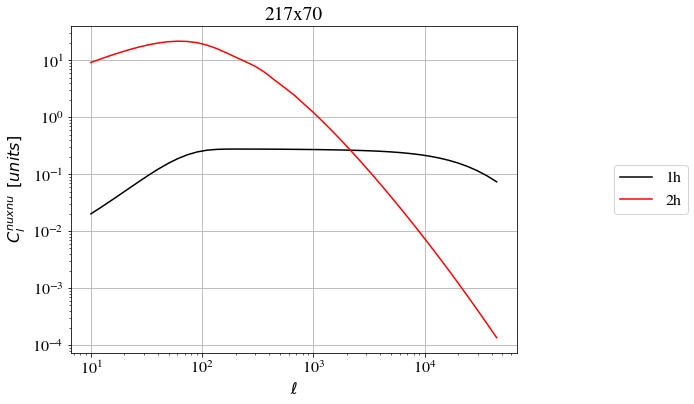

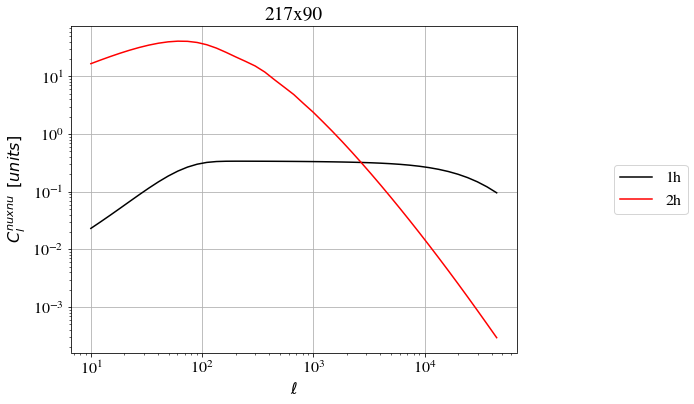

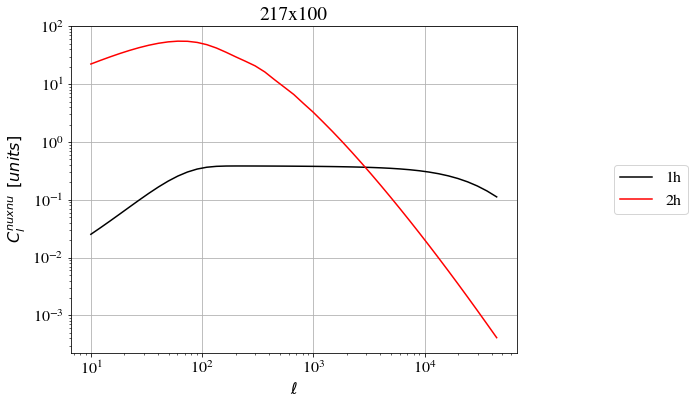

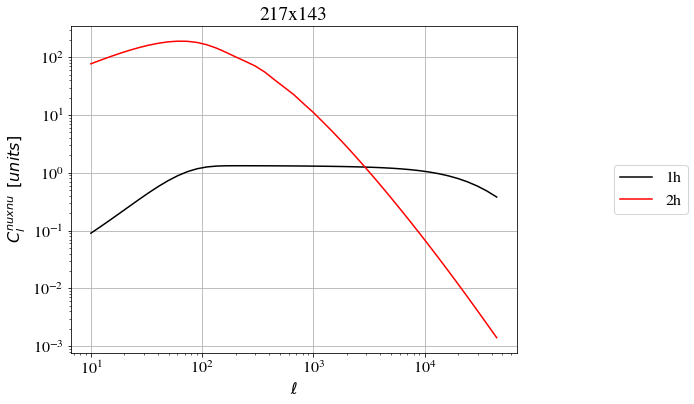

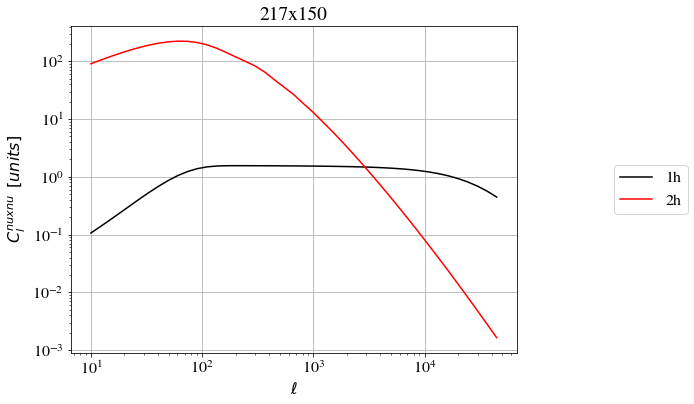

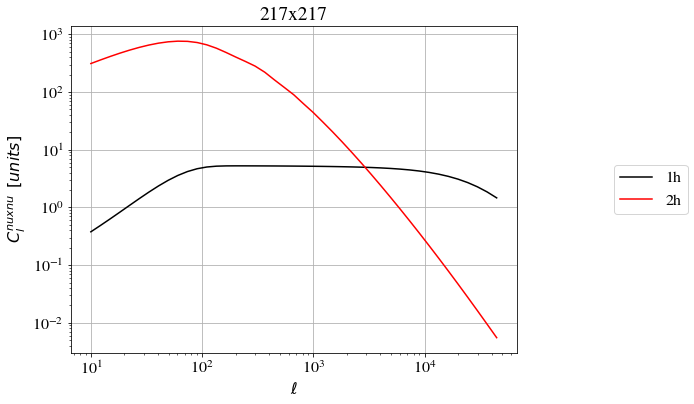

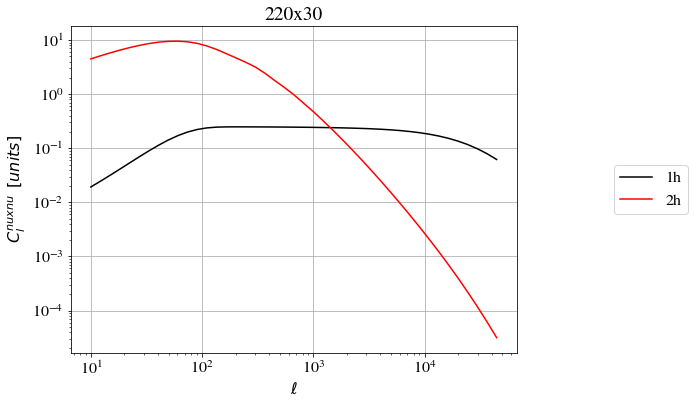

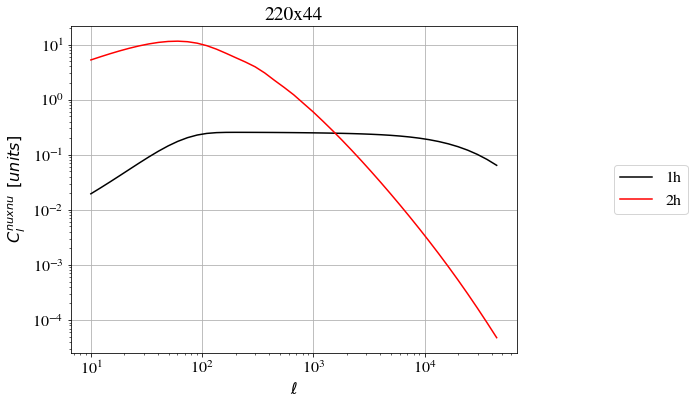

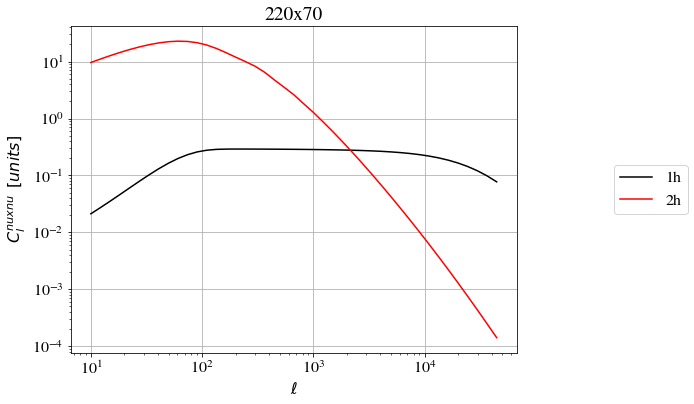

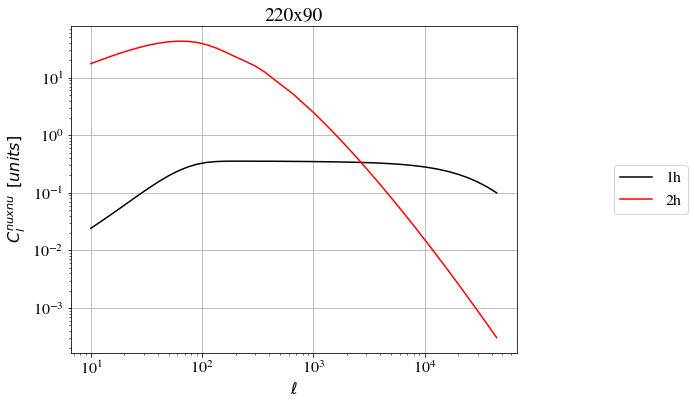

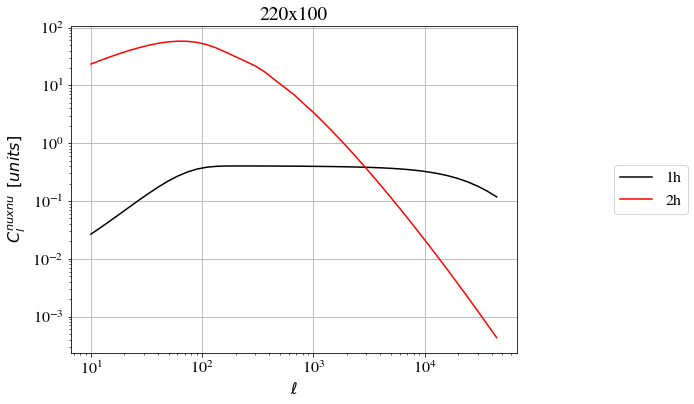

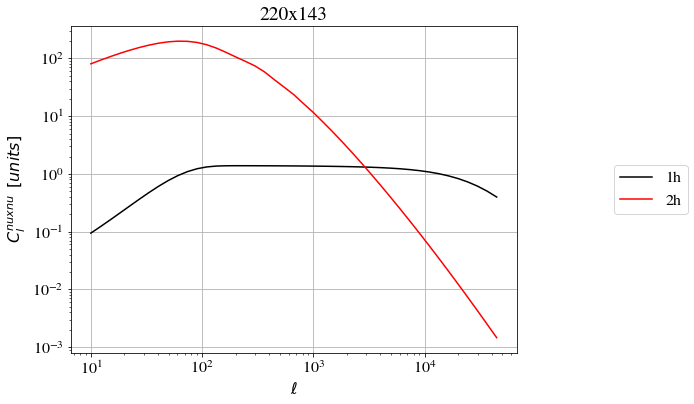

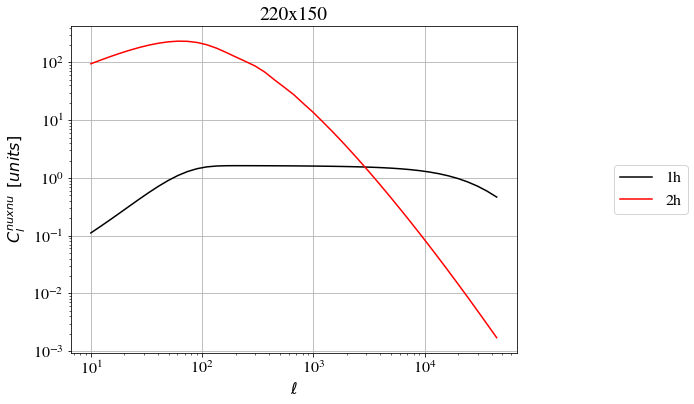

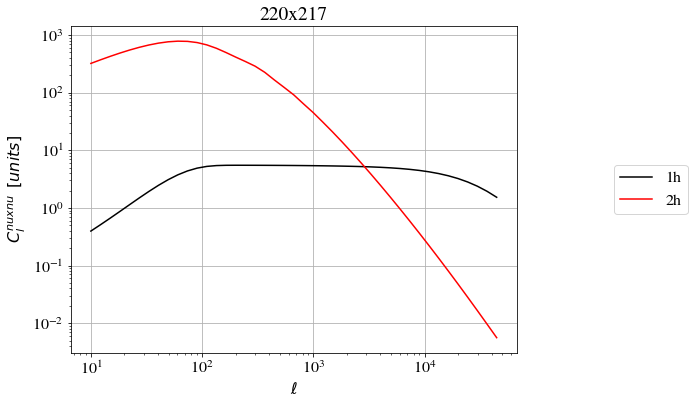

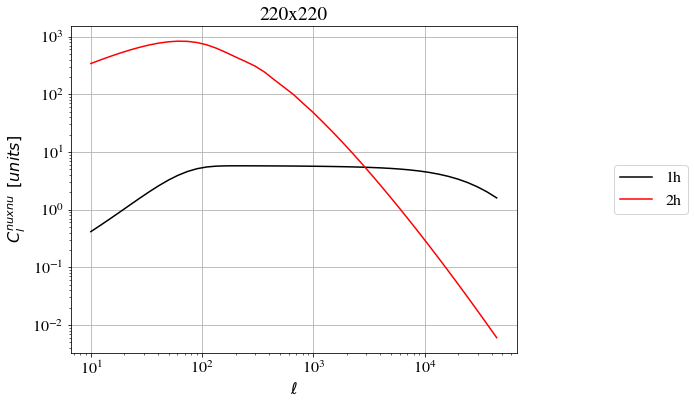

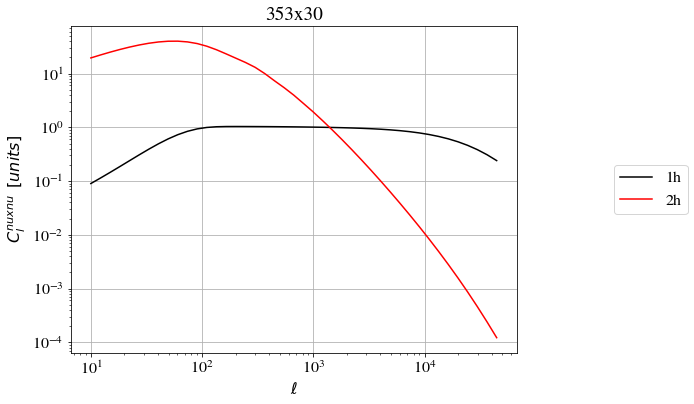

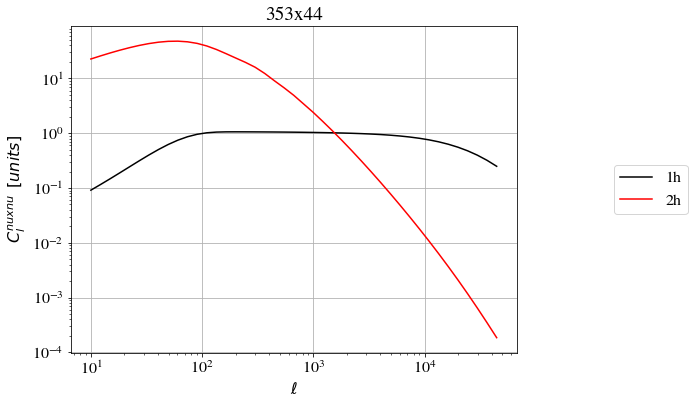

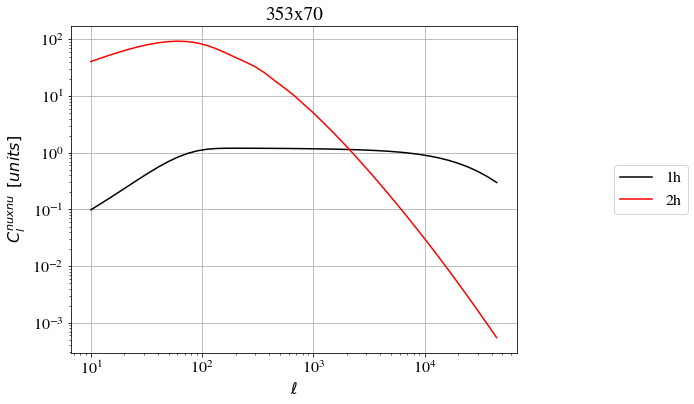

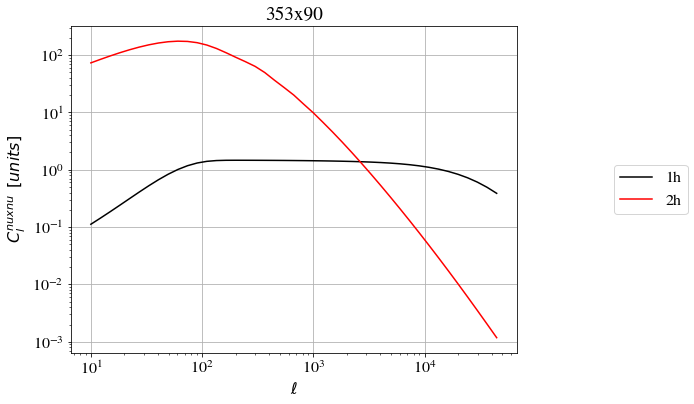

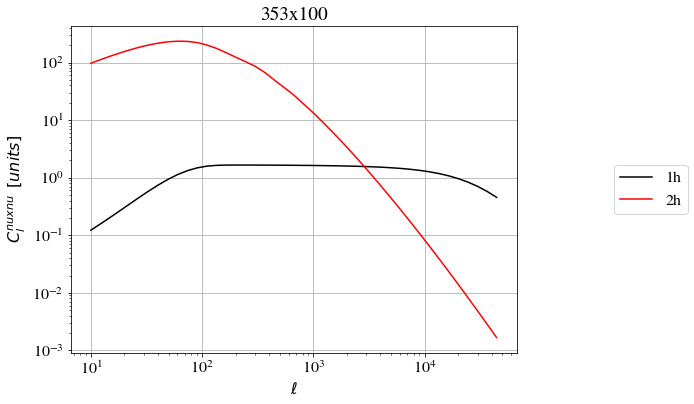

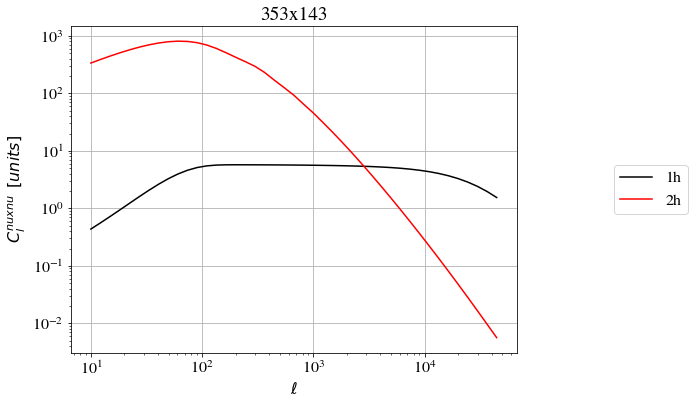

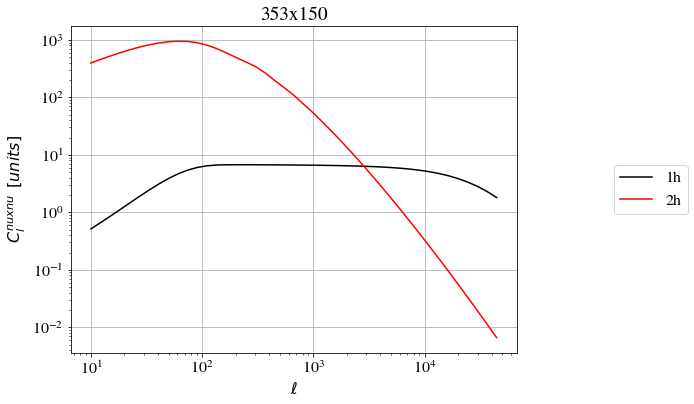

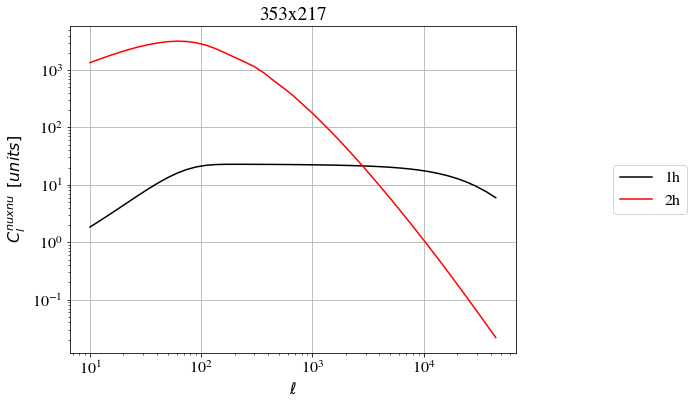

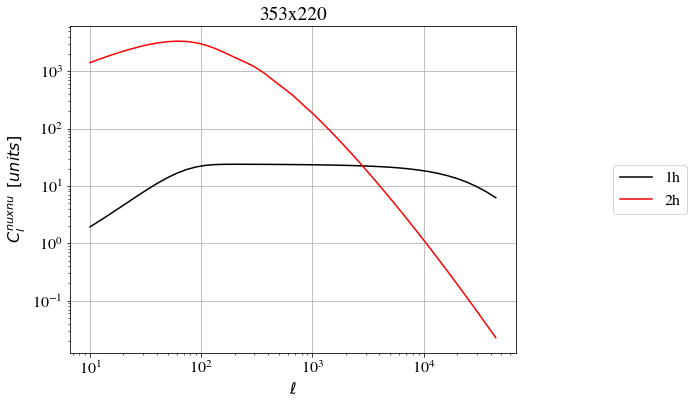

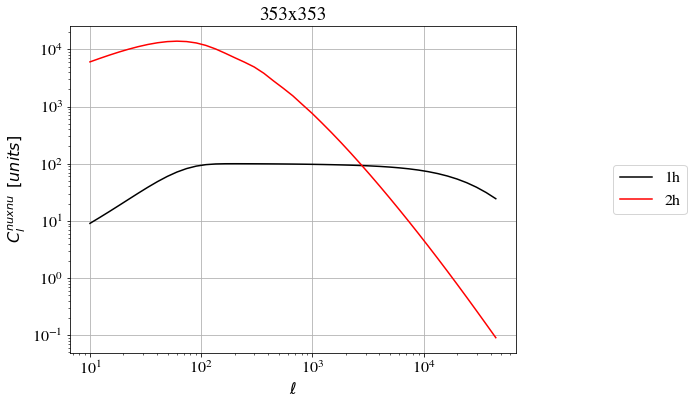

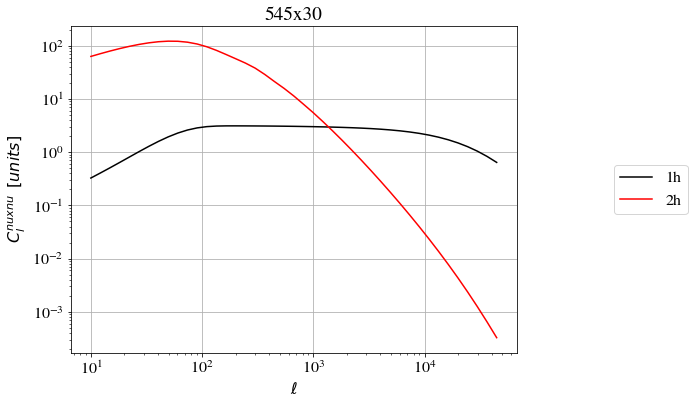

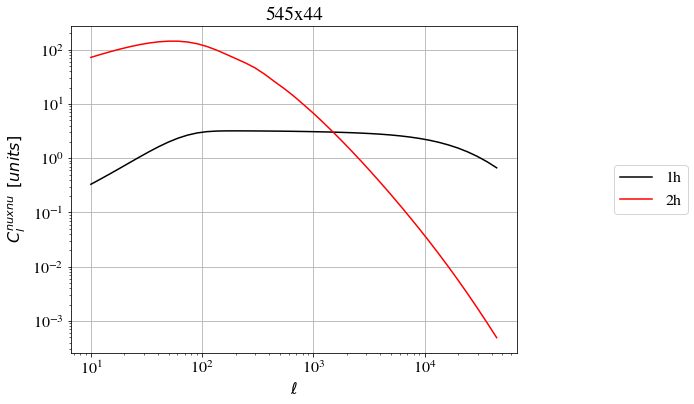

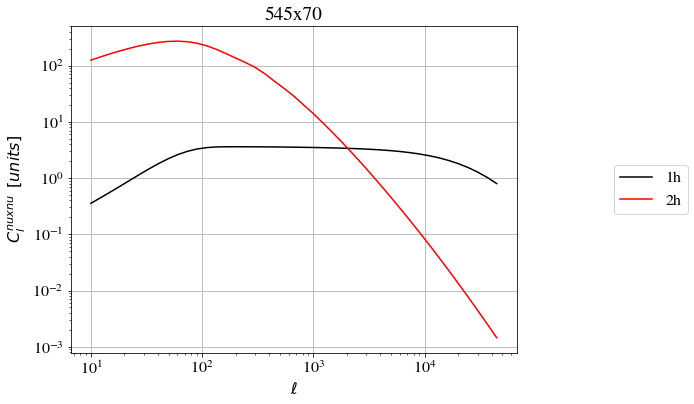

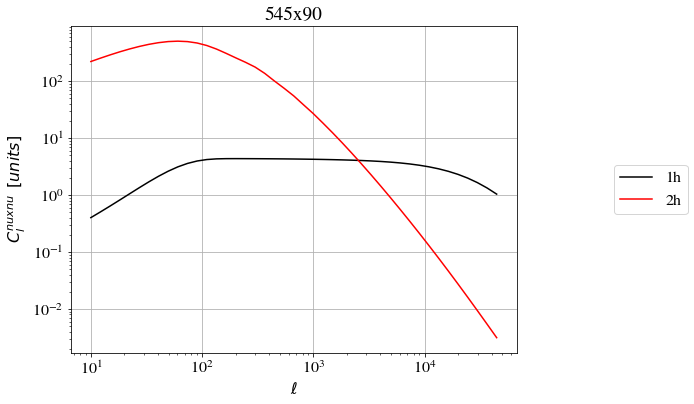

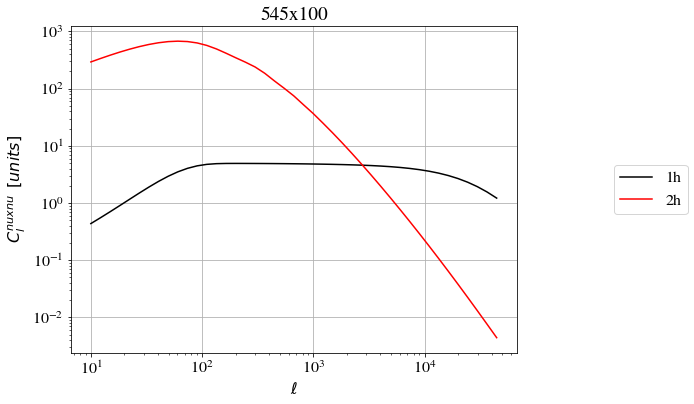

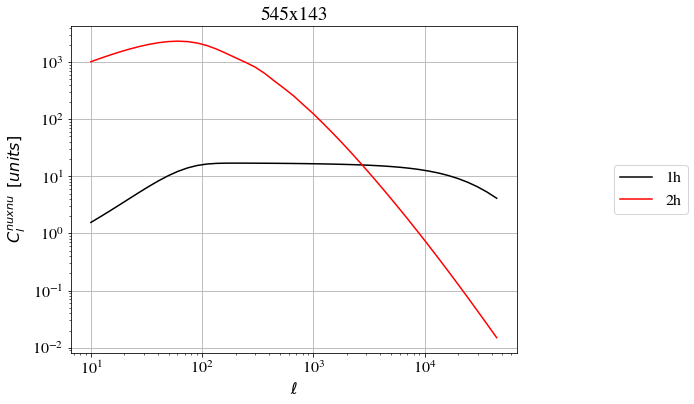

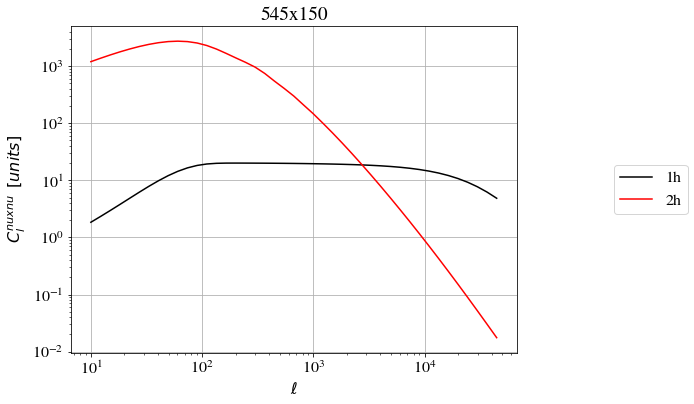

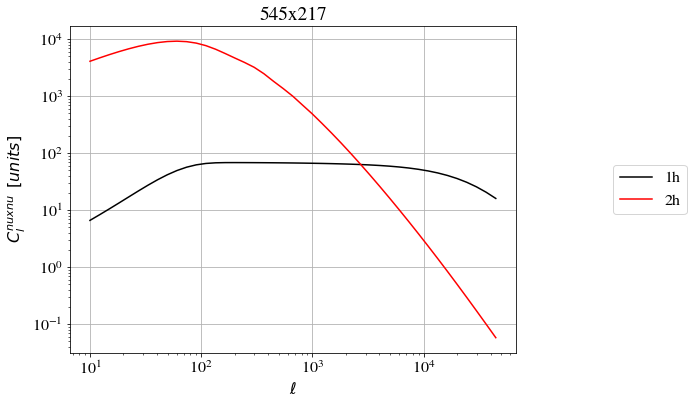

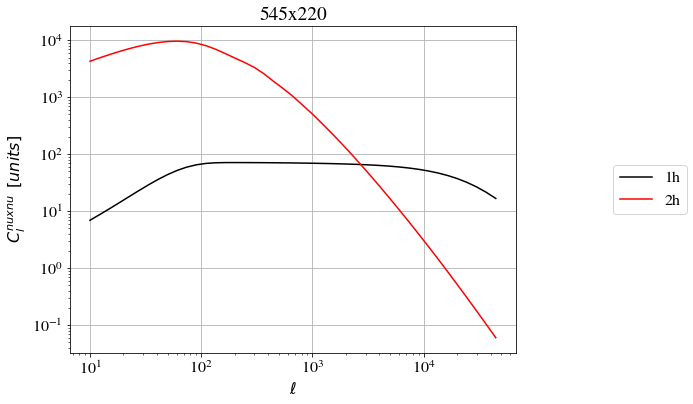

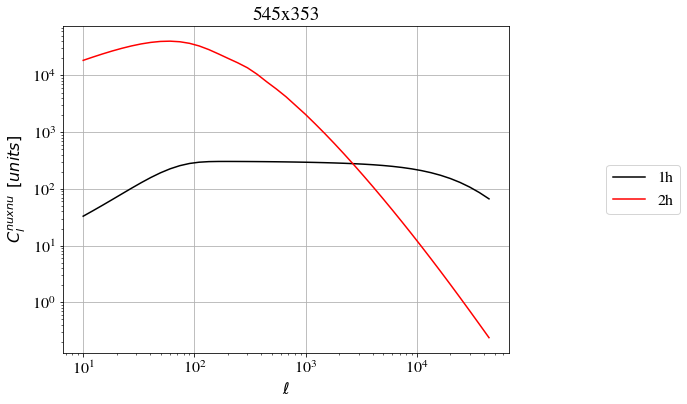

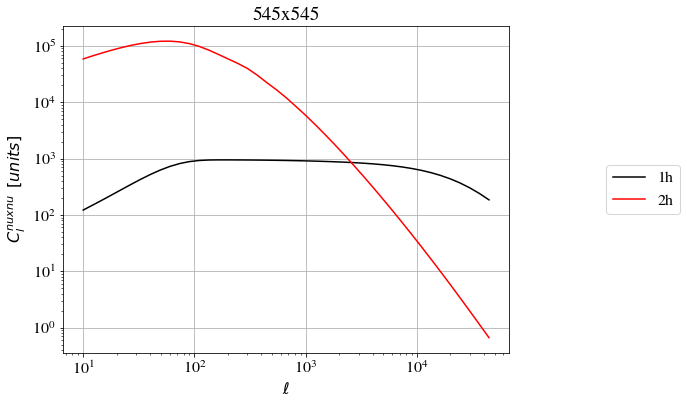

In [43]:
for kk in cl_cib_cib.keys():
    fig = plt.figure()
    plt.title(kk)
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$C_l^{nuxnu} \,\,\, [units]$")

    plt.grid()
    #
    cl = cl_cib_cib[kk]
    fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

    plt.loglog(cl['ell'],np.asarray(cl['1h'])/fac,'k-',label=r'1h')
    plt.loglog(cl['ell'],np.asarray(cl['2h'])/fac,'r-',label=r'2h')
    plt.legend(loc='right',bbox_to_anchor=(1.4, 0.5))

cib power spectra as a function of flux cut

table 1 of https://arxiv.org/pdf/1309.0382.pdf <br>
1: freq GHz 2: Flux cut mJy<br>
100 - 400<br>
143 - 350<br>
217 - 225<br>
353 - 315<br>
545 - 350<br>
857 - 710<br>
3000  - 1000<br>

In [36]:
M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'cib_cib_1h,cib_cib_2h', 
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun/Hz]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M_min' : 1e10*common_settings['h'],
        'M_max' : 1e16*common_settings['h'],
    
        'z_min' : 0.07,
        'z_max' : 6,
    
        'ell_min': 10.,
        'ell_max':5e4,
        'dlogell':0.2,
    
       'cib_frequency_list_num' : 1,
       'cib_frequency_list_in_GHz' : '3000.',
        'has_cib_flux_cut' : 1,
        'cib_Snu_cutoff_list [mJy]': '1000.'
        })
        
cl_cib_cib = []
fc_arr = np.geomspace(100.,1000.,3)
for fc in fc_arr:
    M.set({'cib_Snu_cutoff_list [mJy]':str(fc)})
    M.compute()
    cl_cib_cib.append(M.cl_cib_cib())
M.struct_cleanup()
M.empty()

(500.0, 600000.0)

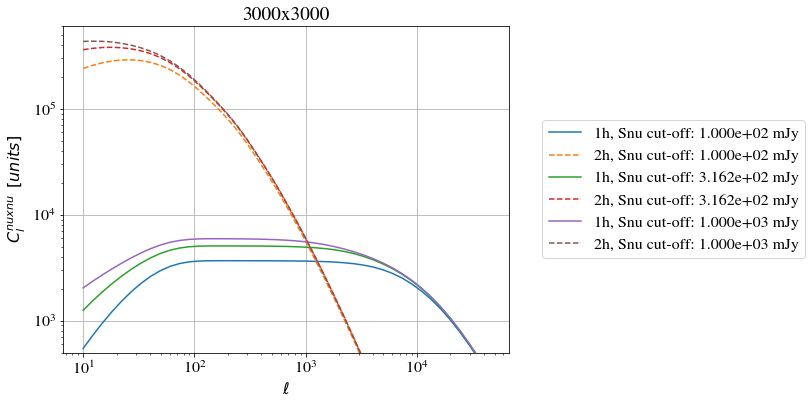

In [41]:
fig = plt.figure()
for (ifc,fc) in enumerate(fc_arr):
    for kk in cl_cib_cib[ifc].keys():
        
        plt.title(kk)
        plt.xlabel(r"$\ell$")
        plt.ylabel(r"$C_l^{nuxnu} \,\,\, [units]$")

        plt.grid()
        #
        cl = cl_cib_cib[ifc][kk]
        fac = np.asarray(cl['ell'])*(np.asarray(cl['ell'])+1.)/2./np.pi

        plt.loglog(cl['ell'],np.asarray(cl['1h'])/fac,ls='-',label=r'1h, Snu cut-off: %.3e mJy'%fc)
        plt.loglog(cl['ell'],np.asarray(cl['2h'])/fac,ls='--',label=r'2h, Snu cut-off: %.3e mJy'%fc)
plt.legend(loc='right',bbox_to_anchor=(1.68, 0.5))
plt.ylim(5e2,6e5)

In [4]:

M = Class()
M.set(common_settings)
M.set({# class_sz parameters:
       'output':'tSZ_lens_1h,tSZ_lens_2h', 
    
        'mass function': 'T10',
        'concentration parameter' : 'D08',
        'hm_consistency': 1,
       'Redshift evolution of dust temperature' :  0.36,
       'Dust temperature today in Kelvins' : 24.4,
       'Emissivity index of sed' : 1.75,
       'Power law index of SED at high frequency' : 1.7,
       'Redshift evolution of L − M normalisation' : 3.6,
       'Most efficient halo mass in Msun' : 10.**12.6,
       'Normalisation of L − M relation in [Jy MPc2/Msun]' : 6.4e-8,
       'Size of of halo masses sourcing CIB emission' : 0.5,

        # M_min_HOD is the threshold above which nc = 1:
        'M_min_HOD' : 10.**10,

        'M_min' : 1e10*common_settings['h'],
        'M_max' : 1e16*common_settings['h'],
        'z_min' : 0.07,
        'z_max' : 6,
        'ell_min': 10.,
        'ell_max':5e4,
        'dlogell':0.2,
    
#        'cib_frequency_list_num' : 3,
#        'cib_frequency_list_in_GHz' : '100, 143, 150',
        })
        
M.compute()
# cl_cib_cib = M.cl_cib_cib()
# M.struct_cleanup()
# M.empty()

[]

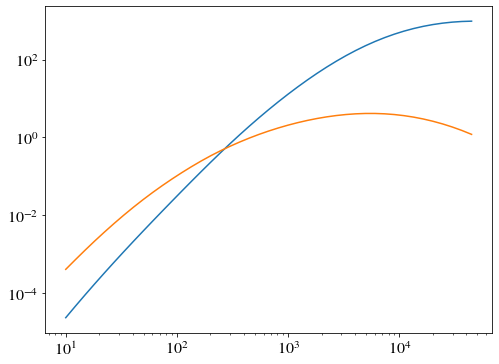

In [7]:
plt.plot(M.cl_y_kcmb()['ell'],M.cl_y_kcmb()['1h'])
plt.plot(M.cl_y_kcmb()['ell'],M.cl_y_kcmb()['2h'])
plt.loglog()